In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d,gaussian_filter
import pickle
from skimage import io, filters
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
# load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
warp_directory = os.path.join(func_path,'warp')
load_dir = os.path.join(warp_directory,  'test.h5')

In [3]:
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def apply_butter_highpass(data, z, cutoff, order, fs):

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)
    hpf_data = butter_highpass_filter(data[:,:,z, :], cutoff, fs, order)
    return hpf_data

In [4]:
#filter requirements 
order = 2     # ?? wtf is this??
fs = 1.8      # sample rate, Hz
cutoff = 0.01  # desired cutoff frequency of the filter, Hz

In [5]:
%%time
#from warps

with h5py.File(load_dir, 'r') as wf:
        warps = wf['data'][:]
        ts=wf['timestamps'][:]
        dims = np.shape(warps)
        dimsts = np.shape(ts)
        print("Data shape is {} and TimeStamps shape is {}".format(dims, dimsts))

Data shape is (314, 146, 91, 500) and TimeStamps shape is (314, 146, 91, 500)
CPU times: user 250 µs, sys: 8.58 s, total: 8.58 s
Wall time: 1min 16s


In [6]:
# warps = np.rollaxis(warps,0,4)
print(np.shape(warps))

(314, 146, 91, 500)


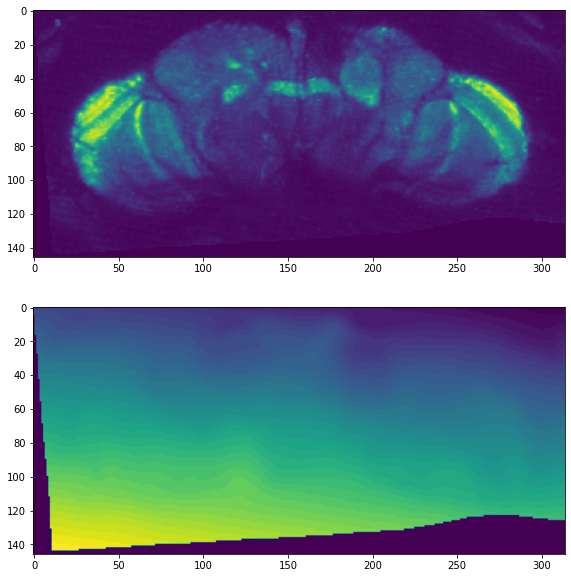

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(np.max(warps[:,:,20,:],axis=-1).T)
plt.subplot(2,1,2)
plt.imshow(np.max(ts[:,:,20,:],axis=-1).T)

In [8]:
%%time
warps_blur=[]
for i in range(np.shape(warps)[-1]):
    warps_temp = gaussian_filter(warps[...,i], sigma=2)
    warps_blur.append(warps_temp)
warps_blur=np.asarray(warps_blur)

print(np.shape(warps_blur))

(500, 314, 146, 91)
CPU times: user 41.8 s, sys: 3.33 s, total: 45.2 s
Wall time: 45.2 s


In [9]:
warps_blur=np.moveaxis(warps_blur,0,-1)
np.shape(warps_blur)

(314, 146, 91, 500)

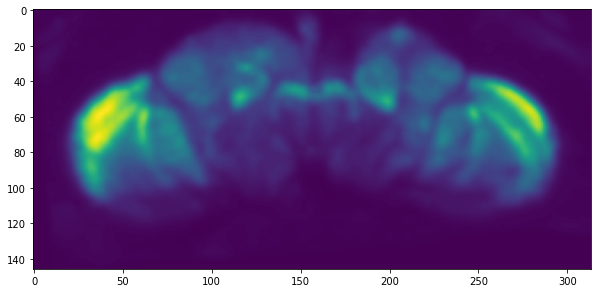

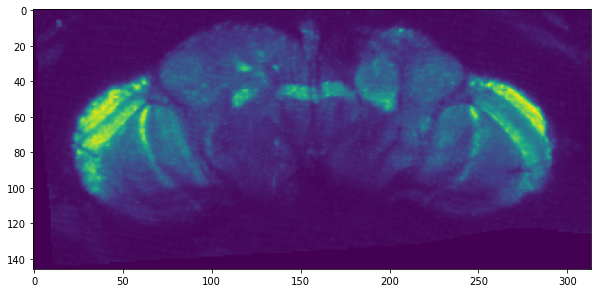

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(warps_blur[:,:,20,:], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(warps[:,:,20,:],axis=-1).T)

In [11]:
#############
#CHANGE THIS#
#############

warp_def=warps_blur

In [12]:
%%time
hpf_total = []
for z in range(dims[-2]):
    hpf_warps = apply_butter_highpass(warp_def, z, cutoff, order, fs)
    hpf_total.append(hpf_warps)
hpf_total = np.array(hpf_total)
hpf_total = np.transpose(hpf_total, (1,2,0,3))
dims_hpfw = np.shape(hpf_total)
print("High Pass Filter Data shape is {}".format(dims_hpfw))

High Pass Filter Data shape is (314, 146, 91, 500)
CPU times: user 40.1 s, sys: 13.2 s, total: 53.2 s
Wall time: 53.2 s


In [13]:
lpf_total = warp_def-hpf_total
print(np.shape(lpf_total))

(314, 146, 91, 500)


In [14]:
fixed = brainsss.load_fda_meanbrain()

In [15]:
dff=hpf_total/(lpf_total-lpf_total.min()+100)
print(dff.mean())
dff=np.where(fixed.numpy()[...,None]>0.1, dff, 0)
print(dff.max())

0.00036129114435253814
1.732115072774681


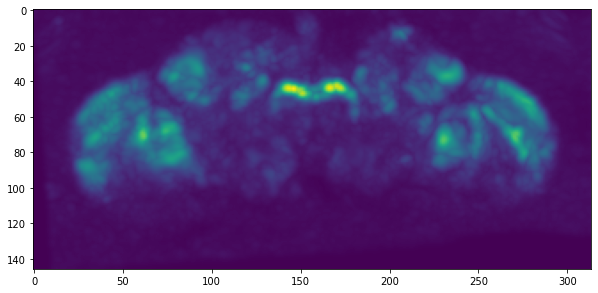

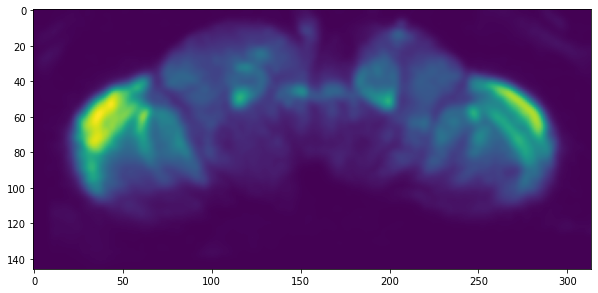

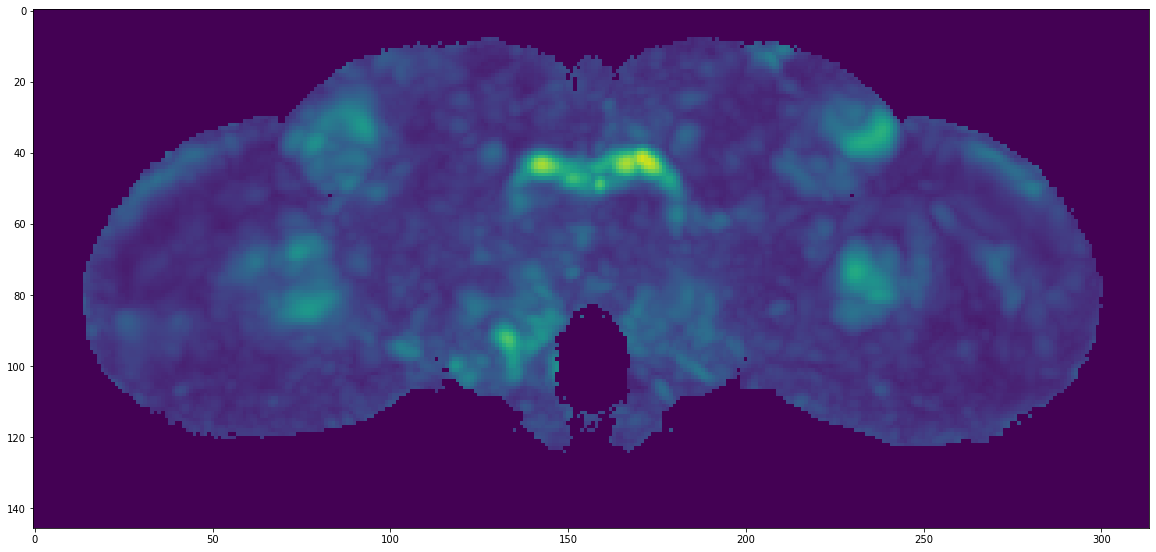

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(hpf_total[:,:,20, :], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(lpf_total[:,:,20, :], axis=-1).T)
plt.figure(figsize=(20,20))
plt.imshow(np.max(dff[:,:,20, :], axis=-1).T, vmax=1,vmin=0)

In [17]:
brain=dff

In [18]:
shape=np.shape(brain)
print(shape)

(314, 146, 91, 500)


In [19]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms

####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX', 'speed']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

loading photodiode data... done


In [20]:
def extract_traces(fictrac, stim_times, pre_window, post_window, val=None):
    traces = []
    for i in range(len(stim_times)):
        if val != None:
            trace = fictrac[val][stim_times[i]-pre_window:stim_times[i]+post_window]
        else:
            trace = fictrac[stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [21]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
stim_time = 100
# window = np.arange(-pre_window,post_window)

behavior_traces = {}
mean_trace = {}
sem_trace = {}
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac['Y'], starts_loom, pre_window, post_window)

In [22]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    
    plt.figure(figsize=(10,10))
    plt.plot(mean_trace,color='k',linewidth=3)
    plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    plt.axvline(pre_window,color='k',linestyle='--',lw=2)
    plt.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
    plt.ylim(-0.5, 3.5);

In [23]:
np.shape(behavior_traces)

(198, 500)

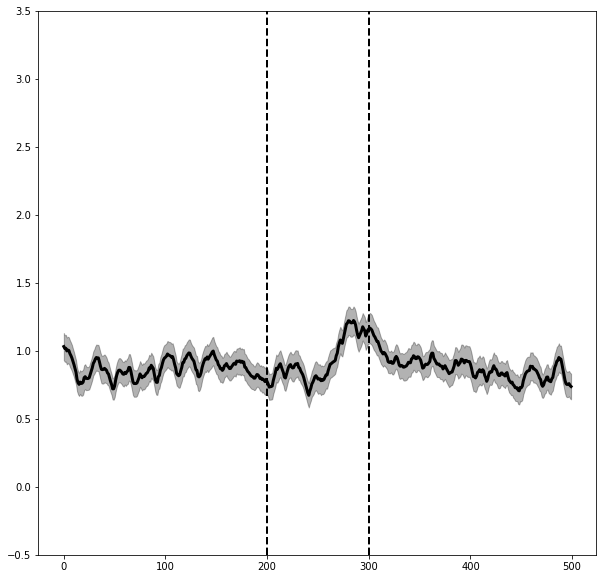

In [24]:
plot_trace(behavior_traces, pre_window, post_window, stim_time)

In [25]:
starts_loom_ms=[n*10 for n in starts_loom]

In [26]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [27]:
bool_starts=(starts_loom_ms>=(np.min(ts))) & (starts_loom_ms<=(np.max(ts)))
starts_loom_ms=np.array(starts_loom_ms)
starts_loom_ms=starts_loom_ms[bool_starts]

In [28]:
bins_array=[]
for loom in starts_loom_ms:
#     print(loom)
    start=loom+bin_start
    end=loom+bin_end-bin_size
#     edges=[start,end]
    bins_array.append(start)
    bins_array.append(end)
# bins_test=np.vstack(bins_test)
bins_array=np.array(bins_array)
np.shape(bins_array)

(70,)

In [29]:
print(np.shape(brain))
print(len(starts_loom_ms))

(314, 146, 91, 500)
35


In [30]:
np.shape(ts)

(314, 146, 91, 500)

In [31]:
%%time
bin_idx = np.digitize(ts, bins_array)

CPU times: user 13.4 s, sys: 5.08 s, total: 18.5 s
Wall time: 18.5 s


In [32]:
%%time

# make loom-relative version of ts
ts_rel = ts.copy()

# Loop through each loom-containing bin_idx and subtract starts_loom_ms
for i in range(len(starts_loom_ms)):
    # subtract loom onset time for corresponding timestamps
    ts_rel[bin_idx == i*2 + 1] -= starts_loom_ms[i]

# boolean mask of where bin_idx is odd
odd_mask = bin_idx % 2 == 1

# Create flattened (xyz X time) 
n_timesteps = ts_rel.shape[-1]
ts_rel_flat = ts_rel.reshape(-1, n_timesteps)
brain_flat = brain.reshape(-1, n_timesteps)
odd_mask_flat = odd_mask.reshape(-1, n_timesteps)

# Collect ts_rel and brain elements that fall within loom window / bin
within_bin_brain_flat  = [brain_flat[xyz][odd_mask_flat[xyz]] for xyz in range(brain_flat.shape[0])]
within_bin_ts_rel_flat = [ts_rel_flat[xyz][odd_mask_flat[xyz]] for xyz in range(ts_rel_flat.shape[0])]

# Find the maximum length of the sublists
max_len = max(len(sublist) for sublist in within_bin_brain_flat)

# Create a 2D NumPy array filled with np.nan, with the appropriate shape
n_voxels = len(within_bin_brain_flat)
within_bin_brain_flat_np = np.full((n_voxels, max_len), np.nan)
within_bin_ts_rel_flat_np = np.full((n_voxels, max_len), np.nan)

# Populate the array with the values from the original list of lists
for i, (brain_sl, ts_rel_sl) in enumerate(zip(within_bin_brain_flat, within_bin_ts_rel_flat)):
    within_bin_brain_flat_np[i, :len(brain_sl)] = brain_sl
    within_bin_ts_rel_flat_np[i, :len(ts_rel_sl)] = ts_rel_sl

# unflatten
static_brain_shape = brain.shape[:-1]
within_bin_brain_np = within_bin_brain_flat_np.reshape(*static_brain_shape, max_len)
within_bin_ts_rel_np = within_bin_ts_rel_flat_np.reshape(*static_brain_shape, max_len)    

CPU times: user 1min 27s, sys: 30 s, total: 1min 57s
Wall time: 1min 57s


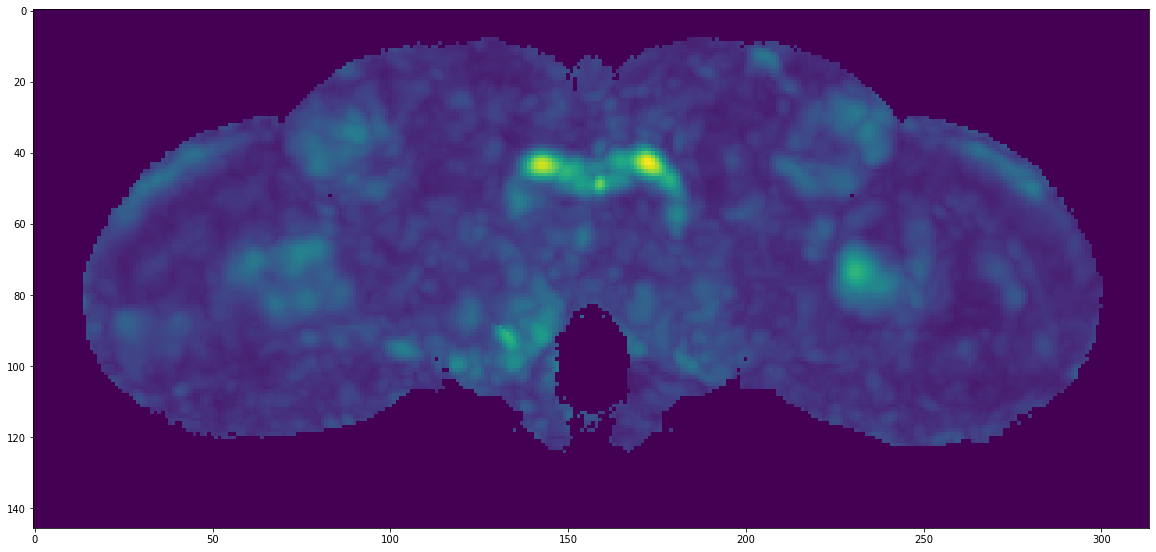

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(within_bin_brain_np[:,:,20], axis=-1).T)

In [34]:
within_bin_brain_np.shape

(314, 146, 91, 162)

In [35]:
within_bin_ts_rel_np.shape

(314, 146, 91, 162)

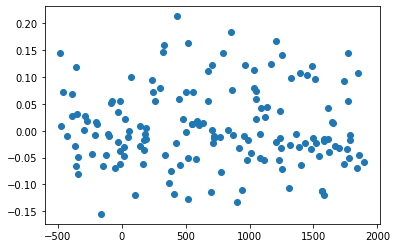

In [36]:
plt.scatter(within_bin_ts_rel_np[100,50,20], within_bin_brain_np[100,50,20])

In [37]:
%%time
dff_dir = os.path.join(func_path, 'dff')
if os.path.exists(dff_dir)==False:
    os.mkdir(dff_dir)
print(dff_dir)
dff_path = os.path.join(dff_dir,  'test_dff.h5')
with h5py.File(dff_path, "w") as data_file:
    data_file.create_dataset("data", data=within_bin_brain_np.astype('float32'))
    data_file.create_dataset("timestamps", data=within_bin_ts_rel_np.astype('float32'))

/oak/stanford/groups/trc/data/Ilana/2P/data/fly_208/dff
CPU times: user 632 ms, sys: 3.15 s, total: 3.78 s
Wall time: 42.6 s


In [38]:
%%time
dff_dir = os.path.join(func_path, 'dff')
dff_path = os.path.join(dff_dir,  'test_dff.h5')
with h5py.File(dff_path, 'r') as hf:
        brain = hf['data'][:]
        ts = hf['timestamps'][:]
        dimsw = np.shape(brain)
        dimsts = np.shape(ts)
        print("Data shape is {} and timestamps shape is {}".format(dimsw, dimsts))

Data shape is (314, 146, 91, 162) and timestamps shape is (314, 146, 91, 162)
CPU times: user 936 µs, sys: 1.69 s, total: 1.69 s
Wall time: 1.96 s


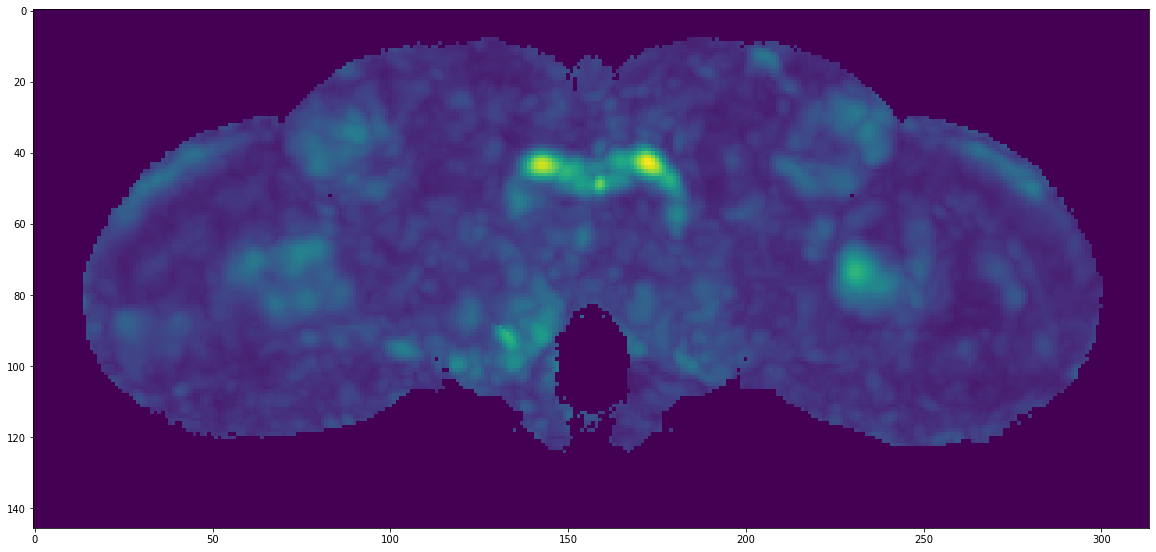

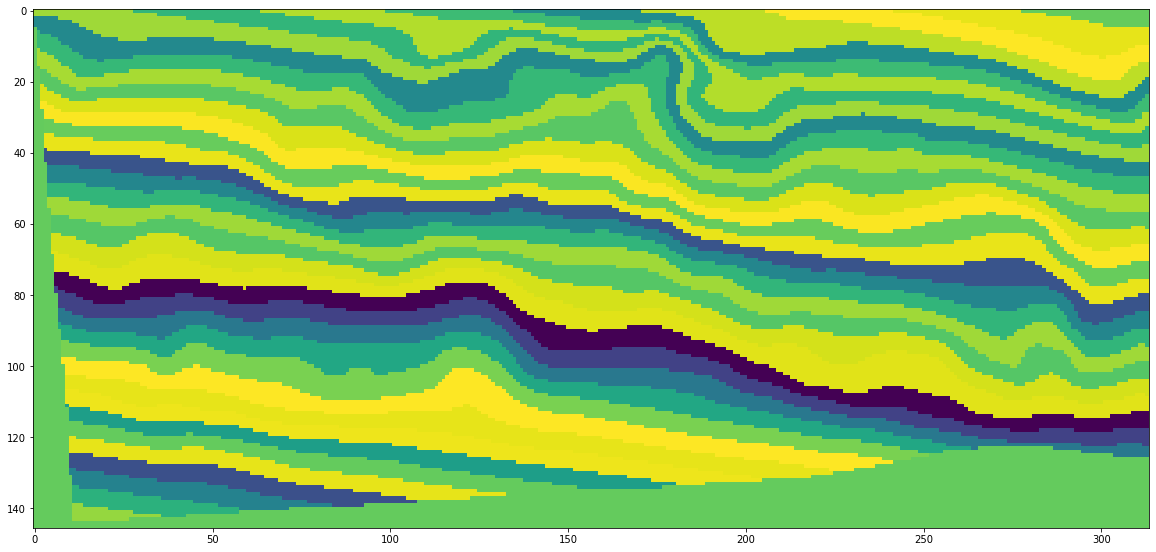

In [47]:
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(brain[:,:,20], axis=-1).T)
plt.figure(figsize=(20,20))
plt.imshow(np.nanmax(ts[:,:,20], axis=-1).T)

In [48]:
ts[100,50,20]

array([ -52.1875,  479.8125, 1011.8125, 1543.8125, -146.1875,  385.75  ,
        917.75  , 1449.75  , -460.25  ,   71.75  ,  603.6875, 1135.6875,
       1667.6875, -360.3125,  171.6875,  703.625 , 1235.625 , 1767.625 ,
       -482.375 ,   49.625 ,  581.5625, 1113.5625, 1645.5625, -362.4375,
        169.5   ,  701.5   , 1233.5   , 1765.5   , -190.5625,  341.4375,
        873.4375, 1405.4375,  -12.625 ,  519.375 , 1051.375 , 1583.375 ,
       -354.6875,  177.3125,  709.3125, 1241.3125, 1773.3125, -204.75  ,
        327.25  ,  859.25  , 1391.25  ,  -78.75  ,  453.1875,  985.1875,
       1517.1875, -344.8125,  187.1875,  719.1875, 1251.125 , 1783.125 ,
       -164.875 ,  367.125 ,  899.125 , 1431.0625,  -12.9375,  519.    ,
       1051.    , 1583.    , -387.    ,  145.    ,  676.9375, 1208.9375,
       1740.9375,  -87.0625,  444.9375,  976.875 , 1508.875 , -427.125 ,
        104.8125,  636.8125, 1168.8125, 1700.8125,  -99.1875,  432.75  ,
        964.75  , 1496.75  , -211.25  ,  320.75  , 

In [49]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
%%time
explosions = []
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)